<a href="https://colab.research.google.com/github/ayush6233/Heart-Disease-Prediction/blob/main/heart_disease_week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Predict whether a patient has heart disease (binary classification).

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df = df.drop_duplicates()
print(df.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Feature engineering

Convert categorical columns (e.g., cp, restecg, slope, thal) to one-hot or ordinal as appropriate.

In [ ]:
cat_cols = ['cp','restecg','slope','thal']
num_cols = [c for c in df.columns if c not in cat_cols + ['target']]

X = pd.get_dummies(df.drop(columns=['target']), columns=cat_cols, drop_first=True)
y = df['target']

Train/test split and scaling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Handle class imbalance

In [ ]:
from sklearn.utils import class_weight
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
print(class_weights)

{0: np.float64(1.0954545454545455), 1: np.float64(0.9198473282442748)}


EDA

Plot distributions, correlations, and check separability.

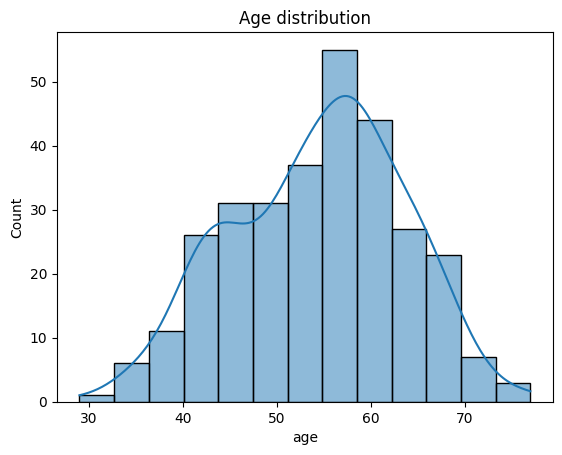

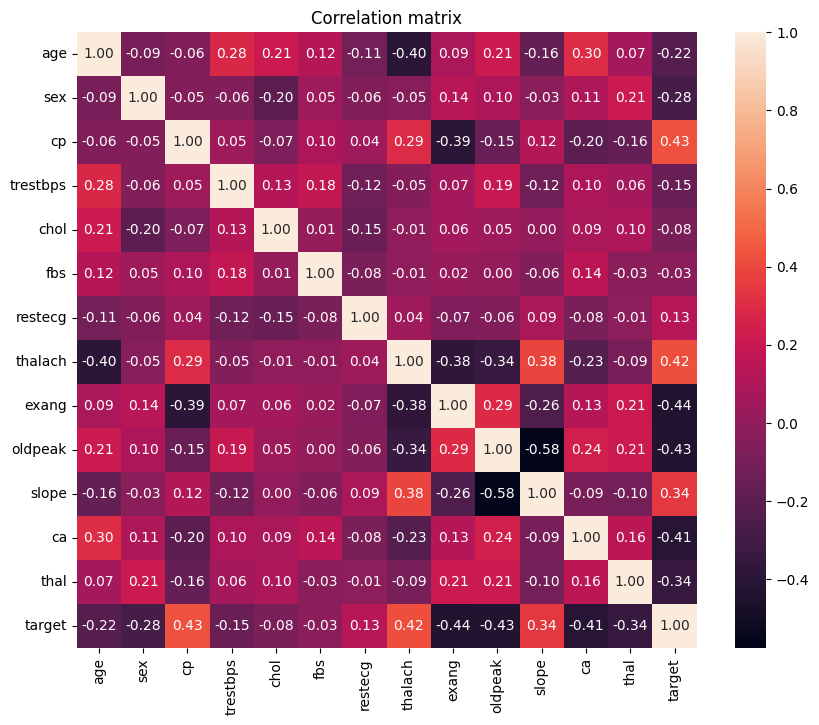

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df.age, kde=True); plt.title('Age distribution'); plt.show()

plt.figure(figsize=(10,8)); sns.heatmap(df.corr(), annot=True, fmt='.2f'); plt.title('Correlation matrix'); plt.show()

Keras ANN (simple, regularized)




Input -> Dense(64, relu, L2) -> Dropout(0.3) -> Dense(32, relu, L2) -> Dropout(0.2) -> Dense(1, sigmoid)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models

input_dim = X_train_s.shape[1]

def build_model(input_dim, l2=1e-3, dropout_rate=0.3):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout_rate/1.5)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    return model

model = build_model(input_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Training & model tuning

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train_s, y_train, validation_split=0.2, epochs=200, batch_size=32,
                    class_weight=class_weights, callbacks=[es, rlr])

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.3751 - auc: 0.3171 - loss: 0.9113 - val_accuracy: 0.5306 - val_auc: 0.4194 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5772 - auc: 0.5360 - loss: 0.7929 - val_accuracy: 0.7143 - val_auc: 0.7930 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6214 - auc: 0.6318 - loss: 0.7496 - val_accuracy: 0.7959 - val_auc: 0.8925 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6839 - auc: 0.7557 - loss: 0.6643 - val_accuracy: 0.7959 - val_auc: 0.9113 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7707 - auc: 0.8554 - loss: 0.6024 - val_accuracy: 0.8163 - val_auc: 0.9211 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7414 - auc: 0.8465 - loss

Use AUC-ROC as primary metric; also show confusion matrix, precision/recall.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
AUC: 0.8658008658008658
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.80      0.73      0.76        33

    accuracy                           0.75        61
   macro avg       0.75      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61



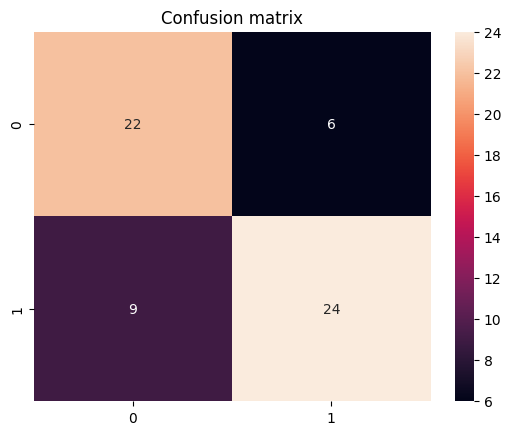

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

pred_proba = model.predict(X_test_s).ravel()
pred = (pred_proba >= 0.5).astype(int)
print('AUC:', roc_auc_score(y_test, pred_proba))
print(classification_report(y_test, pred))

import seaborn as sns
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d'); plt.title('Confusion matrix'); plt.show()

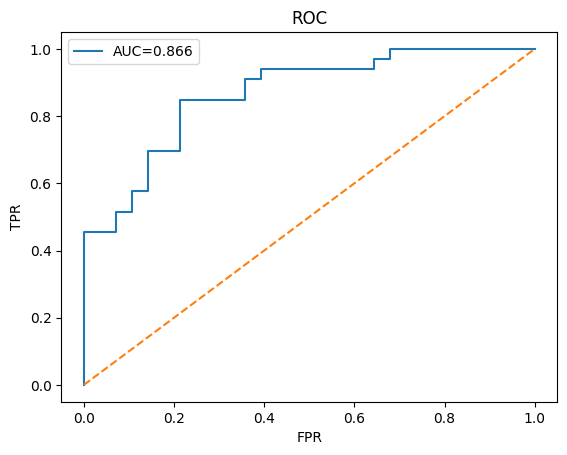

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test,pred_proba):.3f}'); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()